In [95]:
import numpy as np
np.testing.Tester = np.testing.TestCase
import pandas as pd
import json
import scipy
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from feos.si import * # SI numbers and constants
from feos.pcsaft import *
from feos.eos import *

from eyring_entropy import *

msize=12
mwidth = 2
fsize=16
alpha=0.3
lsize = 2
framewidth = 3
markeredgewidth=3
markeredgewidth_no=10

In [ ]:
"""
choose specie, parameter-source and path
"""

saft_paras = "20191105_pure_parameters_feos.json"

name = "propane_bell"
#name = "butanol"
#name = "propanol"

## name = "propane"
#name = "butane"
name = "hexane"
name = "nonane"

name = "water"


savepath = "results/"


In [97]:
"""
build path to save results
"""
try:
    os.mkdir(savepath)
except:
    None

try:
    os.mkdir(savepath+"/"+name)
except:
    None

'pentane'

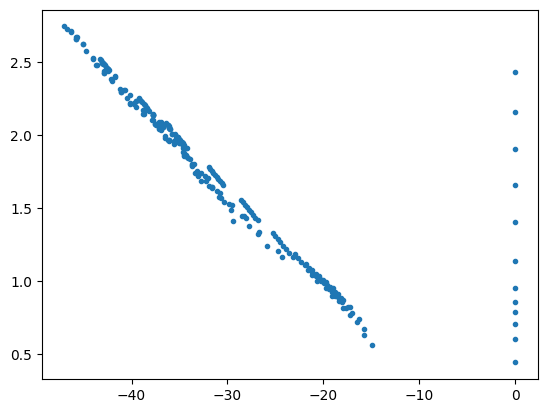

In [ ]:
"""
load and process data

"""

parameters = PcSaftParameters.from_json(
    [name.split("_")[0]], 
    saft_paras, 
    #search_option="name"
)

M = parameters.pure_records[0].molarweight *(GRAM/MOL)
m = parameters.pure_records[0].model_record.m

ppath = "experimental/"+name+"/"+name+"_viscosity_proc.csv"
if os.path.exists(ppath):
    data = pd.read_csv(ppath)
else:
    print("no processed data exists. Utilize calc_stuff(x,parameters) from eyring_entropy.py ")

#plt.plot( data["temperature"], np.log(data["pressure"]), "." )
plt.plot( data["s_res"], np.log(data["viscosity"]/data["eta_CE"]), "." )
name

In [99]:
parameters

|component|molarweight|$m$|$\sigma$|$\varepsilon$|$\mu$|$Q$|$\kappa_{AB}$|$\varepsilon_{AB}$|$N_A$|$N_B$|
|-|-|-|-|-|-|-|-|-|-|-|
|pentane|72.1498|2.74869|3.72936|228.73279|0|0|0|0|1|1|

pentane & x & 298.15 & 428.0 & 6.89 & 702.6 & 5.65 & 2.79\\


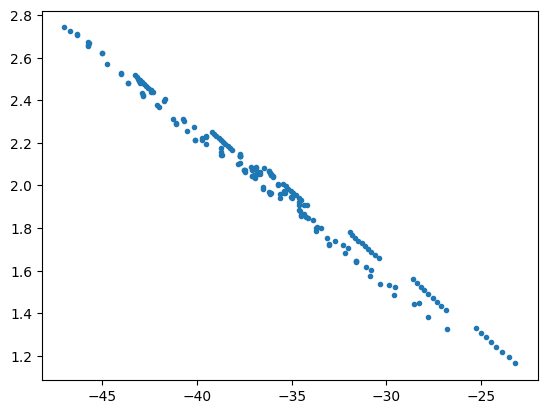

In [100]:
"""
exclude:

- not converged state points
- state points above the pressure limit

"""
eos = EquationOfState.pcsaft(parameters)

critical_point = State.critical_point(eos)

T_crit = critical_point.temperature / KELVIN
rho_crit = critical_point.density *(METER**3/MOL)
V_crit = 1/rho_crit
V_crit

data = data[  data["s_res"] < -0.1  ] # exclude not converged (iG) datapoints
dummy = data[  data["s_res"] < -8  ] # exclude not converged (iG) datapoints
#dummy = data[  data["s_res"] > -120  ]
dummy = dummy[  dummy["pressure"] < 2e8  ]
dummy = dummy[dummy["state"]=="L"]
dummy = dummy[dummy["temperature"]<0.9*T_crit]

if name=="propanol":
    dummy = dummy[  dummy["s_res"] < -50  ]

plt.plot( dummy["s_res"], np.log(dummy["viscosity"]/dummy["eta_CE"]), "." )


maxs = dummy.max(axis=0)
mins = dummy.min(axis=0)
mima = [ str(round(mins["temperature"],2)), str(round(maxs["temperature"],2)),
         str(round(mins["pressure"]/1e5,2)), str(round(maxs["pressure"]/1e5,2)),
         str(round( -mins["s_res"]/8.314,2)), str(round(-maxs["s_res"]/8.314,2))
       ]
print( name+" & x & "+" & ".join(mima) +"\\\\"  )

In [101]:
"""
This shows how the EoS-related outliers in the Bell data were identified and excluded (see plot in SI)

-> dont use, already cleaned, just for showing/transparency

"""
if False:
    vis = dummy["viscosity"]
    log_vis = np.log(vis)
    y_es = log_vis - np.log(dummy["eta_CE"])
    
    es_model = np.polyfit(dummy["s_res"], y_es, 4)            
    
    
    es_pred = np.poly1d(es_model)(dummy["s_res"])
    
    plt.plot( dummy["s_res"], y_es, "kx" )
    
    plt.plot( dummy["s_res"], es_pred, "." )
    plt.plot( dummy["s_res"], es_pred+0.1, "g." )
    plt.plot( dummy["s_res"], es_pred-0.1, "g." )
    plt.show()
    plt.close()

    plt.plot( dummy["s_res"], y_es, "rx" )
    
    for i in [0.3,0.2,0.15,0.1, 0.08]:
        vis = dummy["viscosity"]
        log_vis = np.log(vis)
        y_es = log_vis - np.log(dummy["eta_CE"])
        
        es_model = np.polyfit(dummy["s_res"], y_es, 4)            
        
        
        es_pred = np.poly1d(es_model)(dummy["s_res"])
        
        
        plt.plot( dummy["s_res"], es_pred, "." )
    
        diff = np.abs( es_pred-y_es )
        p = np.where(diff<i)
        dummy = dummy.iloc[p]
        
    vis = dummy["viscosity"]
    log_vis = np.log(vis)
    y_es = log_vis - np.log(dummy["eta_CE"])
    plt.plot( dummy["s_res"], y_es, "kx" )
    plt.plot()
    plt.show()

    plt.plot(data["s_res"]/8.314, np.log(data["viscosity"]/data["eta_CE"]), "rx")#,markersize=msize)
    plt.plot(dummy["s_res"]/8.314, np.log(dummy["viscosity"]/dummy["eta_CE"]), "kx")#,markersize=msize)
    
    dummy1 = dummy0[dummy0["state"]=="L"]
    plt.plot(dummy1["s_res"]/8.314, np.log(dummy1["viscosity"]/dummy1["eta_CE"]), "kx")
    
    plt.xlabel(r"$-s_\text{res}~/~R$",fontsize=fsize)
    plt.ylabel(r"$\ln(\eta^\ast)$",fontsize=fsize)
    
    plt.xticks(fontsize=fsize)  
    plt.yticks(fontsize=fsize)  
    
    
    plt.savefig(savepath+"/"+name+"/"+name+"_excl.png",bbox_inches='tight')
    plt.savefig(savepath+"/"+name+"/"+name+"_excl.pdf",bbox_inches='tight')


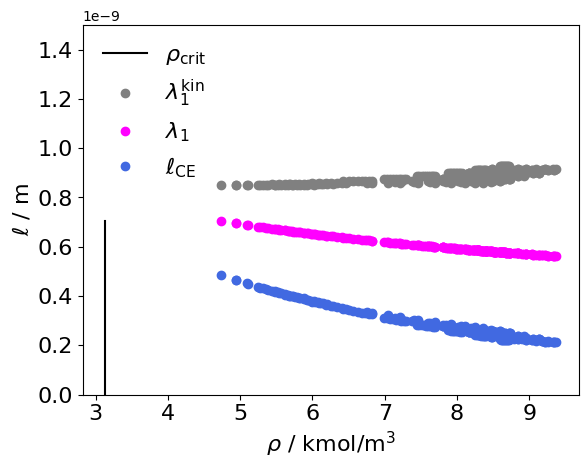

In [102]:
"""
compare free path in kinetic theory and eyring

"""

epsilon = parameters.pure_records[0].model_record.epsilon_k
sigma = parameters.pure_records[0].model_record.sigma

omega = get_omega22(data["temperature"]/epsilon)
ell =  data["V"]/6.02214076e+23/( np.sqrt(2)*np.pi*omega*(sigma /1e10)**2  )
VN = (data["V"]/6.02214076e+23)**(1/3)
llambda = np.sqrt( np.sqrt(2)*np.pi*omega  )*sigma /1e10

plt.plot( [rho_crit/1000,rho_crit/1000], [0,max(VN)] , "k",label=r"$\rho_\text{crit}$")
plt.plot( data["rho"]/1000, llambda, "." , label=r"$\lambda_1^\text{kin}$",markersize=msize,color="grey")
plt.plot( data["rho"]/1000, VN, "." , label=r"$\lambda_1$",markersize=msize,color="magenta")
#plt.plot( data["rho"]/1000, ell0, "." , label=r"$\ell0$",markersize=msize)
plt.plot( data["rho"]/1000, ell, "." , label=r"$\ell_\text{CE}$",markersize=msize,color="royalblue")

#plt.plot( data["rho"], np.max([ell,VN],axis=0), "." , label=r"test")


#plt.ylim(0.5e-9,1.5e-9)
plt.ylim(0,1.5e-9)
plt.legend(frameon=False,fontsize=fsize)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  

plt.xlabel(r"$\rho$ / kmol/m$^3$",fontsize=fsize)
plt.ylabel(r"$\ell$ / m",fontsize=fsize)

plt.savefig(savepath+"/"+name+"/"+name+"_lambda1.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_lambda1.pdf",bbox_inches='tight')

In [103]:
"""

Choose and train Eyring model

Model overview:

EyringEntropyModel: EES1 with diffusion
EyringEntropyModel_EES1: EES1 without diffusion
EyringEntropyModel_EES0: EES0 with diffusion

"""

if name == "nonane":
    ppp = [4.05164485e+00,  1.43872110e-02,  7.43444670e-01, -5.34043343e-02,
        2.81932601e-03]
    model = EyringEntropyModel(parameters, dummy, p=[4.05164485e+00,  1.43872110e-02,  7.43444670e-01, -5.34043343e-02,
        2.81932601e-03])
    print("nonane")
elif name == "butane":
    model = EyringEntropyModel(parameters, dummy, p=[ 3, 0.0, 1.0, .1, .1])
    print("butane")  
elif name == "hexane":
    ppp = [3.13830985e+00,  3.37588500e-02,  6.35243323e-01, -3.75027371e-02,
        2.69059515e-03]
    model = EyringEntropyModel(parameters, dummy, p=ppp)
    print("hexane")        
else:
    model = EyringEntropyModel(parameters, dummy, p=[ 3, 0.0, 1.0, .1, .1])

model.train()

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 12701807.62933599
        x: [ 1.850e+00  2.052e-02  1.000e-01  5.656e-02 -2.674e-03]
      nit: 87
      jac: [-1.729e+02 -1.071e+03  4.931e+05 -1.838e+02  1.729e+02]
     nfev: 750
     njev: 125
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

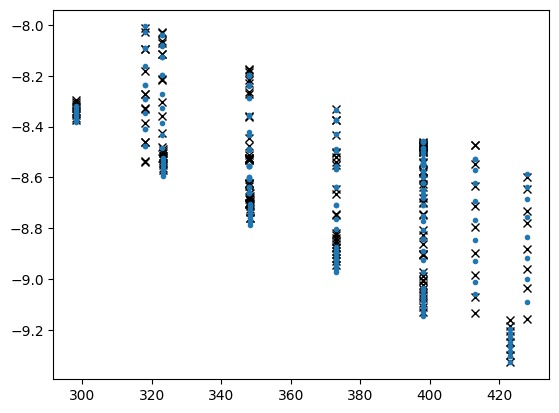

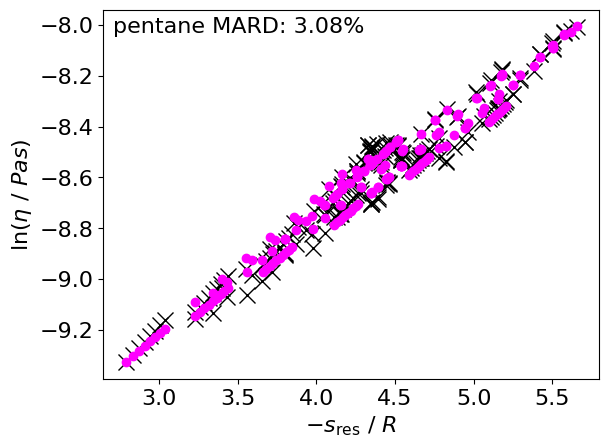

np.float64(3.07779505797478)

In [104]:
"""
predict and show results plus error

"""

y_pred = model.predict()

plt.plot(model.data["temperature"],np.log(model.data["viscosity"]),"kx")
plt.plot(model.data["temperature"],y_pred,".")
plt.show()
plt.close()

fig, ax = plt.subplots()

plt.plot(-model.data["s_res"]/8.314,np.log(model.data["viscosity"]),"kx",markersize=msize)
plt.plot(-model.data["s_res"]/8.314,y_pred,".",color="magenta",markersize=msize)

plt.xlabel(r"$-s_\text{res}~/~R$",fontsize=fsize)
plt.ylabel(r"$\ln(\eta~/~Pas)$",fontsize=fsize)

error = np.mean(np.abs( ( np.exp(y_pred) - model.data["viscosity"]) / model.data["viscosity"] ))*100

plt.text(0.02, 0.98, name.split("_")[0]+' MARD: '+str(round(error,2))+"%",
     fontsize=fsize,
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  


plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy.pdf",bbox_inches='tight')

plt.show()
plt.close()  


error

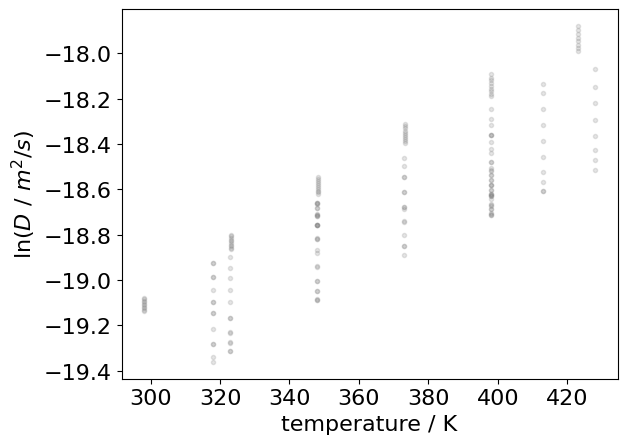

In [105]:
"""
predict diffusion

NOTE: leads to error if diffusion is not implemented ;) Then skip...
"""

y_pred = model.predict_diffusion()

fig, ax = plt.subplots()

#plt.plot(diff_dat["T"], np.log(diff_dat["DIF"]),"kx",markersize=msize)
plt.plot(model.data["temperature"],y_pred,".",color="grey",alpha=0.2)
#plt.plot(diff_dat["temperature"],y_pred_D,".",color="magenta",markersize=msize)

plt.xlabel(r"temperature / K",fontsize=fsize)
plt.ylabel(r"$\ln(D~/~m^2/s)$",fontsize=fsize)

#error = np.mean(np.abs( ( np.exp(y_pred_D) - diff_dat["D"]) / diff_dat["D"] ))
#error = error*100

#plt.text(0.02, 0.98, name.split("_")[0]+' MARD: '+str(round(error,2))+"%",
#     fontsize=fsize,
#     horizontalalignment='left',
#     verticalalignment='top',
#     transform = ax.transAxes)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  

plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_diffusion.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_diffusion.pdf",bbox_inches='tight')


plt.show()
plt.close()

#error

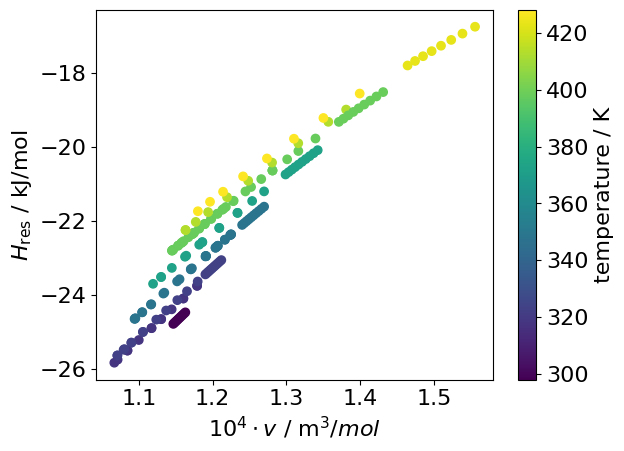

In [106]:
"""
show linearity (SI plot)

"""

cb = plt.scatter(dummy["V"]*10**4, dummy["E_res"]/1000, c=dummy["temperature"])
cb = plt.colorbar(cb, )
cb.set_label(label="temperature / K", size=fsize)
cb.ax.tick_params(labelsize=fsize,)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  

plt.xlabel(r"$10^4 \cdot v$ / m$^3/mol$",fontsize=fsize)
plt.ylabel(r"$H_\text{res}$ / kJ/mol",fontsize=fsize)

plt.savefig(savepath+"/"+name+"/"+name+"_Eres_lin.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_Eres_lin.pdf",bbox_inches='tight')

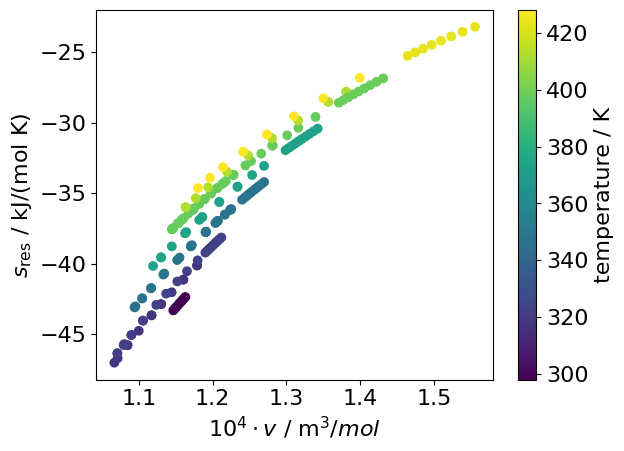

In [107]:
"""
show linearity (SI plot)

"""


cb = plt.scatter(dummy["V"]*10**4, dummy["s_res"], c=dummy["temperature"])
cb = plt.colorbar(cb, )
cb.set_label(label="temperature / K", size=fsize)
cb.ax.tick_params(labelsize=fsize,)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  

plt.xlabel(r"$10^4 \cdot v$ / m$^3/mol$",fontsize=fsize)
plt.ylabel(r"$s_\text{res}$ / kJ/(mol K)",fontsize=fsize)

plt.savefig(savepath+"/"+name+"/"+name+"_Tsres_lin.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_Tsres_lin.pdf",bbox_inches='tight')

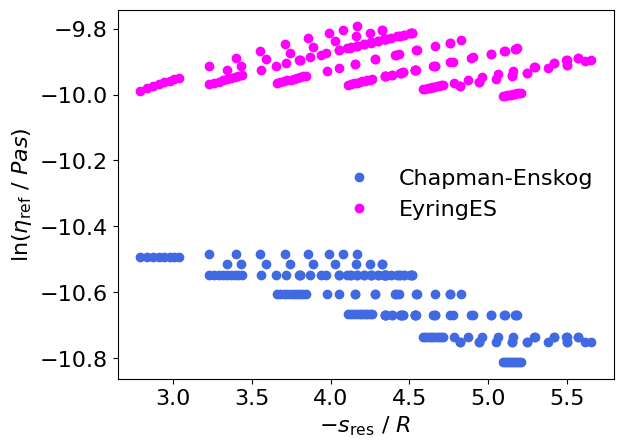

In [108]:
"""
compare references
"""

y_ref = model.predict_eyring_ref()

#plt.plot(model.data["s_res"],np.log(model.data["eta_CE_ig"]),".",label="CE_ig")
plt.plot(-model.data["s_res"]/8.314,np.log(model.data["eta_CE"]),".",label="Chapman-Enskog",markersize=msize,color="royalblue")
plt.plot(-model.data["s_res"]/8.314,y_ref,".",label="EyringES",markersize=msize,color="magenta")
plt.legend(fontsize=fsize,frameon=False)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  

plt.xlabel(r"$-s_\text{res}~/~R$",fontsize=fsize)
plt.ylabel(r"$\ln(\eta_\text{ref}~/~Pas)$",fontsize=fsize)

plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_ref.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_ref.pdf",bbox_inches='tight')


In [109]:
name, model.p

('pentane',
 array([ 1.85041843,  0.02052486,  0.1       ,  0.05655956, -0.00267426]))

propane & 4.3507 & -0.0067 & 1.1415 & -0.138 & 0.0101 \\
butane & 3.1085 & 0.0274 & 0.7034 & -0.0477 & 0.004 \\
hexane & 2.2401 & 0.0348 & 0.2648 & 0.0292 & -0.0012 \\
nonane & 4.0516 & 0.0144 & 0.7434 & -0.0534 & 0.0028 \\
propanol & 3.1152 & 0.0916 & 0.3092 & 0.0137 & 0.0005 \\
butanol & 3.1158 & 0.0891 & 0.4102 & -0.0081 & 0.0014 \\
water & 3.2901 & -0.5737 & 0.2478 & -0.1372 & 0.0152 \\


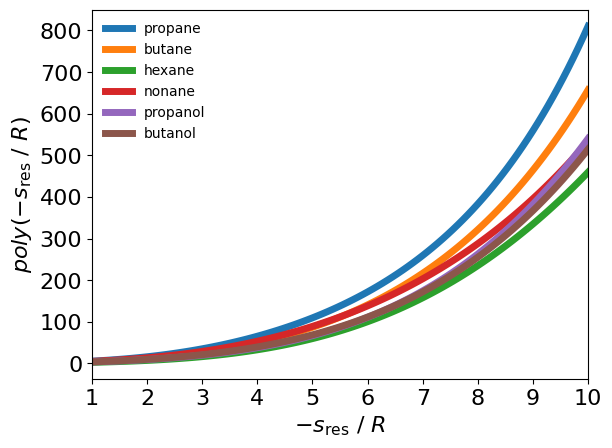

In [ ]:
"""
plot polynomials (SI plot)
"""
# NOTE propane is propane bell here
poly_dict = {
    "propane": [4.35067271, -0.00669079,  1.14151859, -0.13804047,  0.0100586],
    "butane": [3.10853171,  0.02739858,  0.70342853, -0.04765695,  0.00396077],
    "hexane": [2.24007615e+00,  3.47642858e-02,  2.64799776e-01,  2.92067071e-02,
        -1.23554214e-03],
    "nonane": [ 4.05164485e+00,  1.43872110e-02,  7.43444670e-01, -5.34043343e-02,
         2.81932604e-03],
    "propanol": [3.11517568e+00, 9.15570801e-02, 3.09177862e-01, 1.36589110e-02,
       5.39648371e-04],
    "butanol": [ 3.11575710e+00,  8.90830168e-02,  4.10170238e-01, -8.06214172e-03,
        1.44670771e-03 ],
    "water": [3.29008641, -0.57365131,  0.24784286, -0.13721895,  0.01520713 ]
}


x = np.linspace(1,10,100)
for key in poly_dict:
    p = poly_dict[key][::-1]+[0]
    y = np.poly1d(p)(x)
    if key[-3:] != "ane":
    #if key != "water":
        plt.plot(x,y,label=key, linewidth=5)
    kk = key.split("_")
    nn = kk[0]
    print_list = [nn]+[ str(round(x,4)) for x in poly_dict[key] ]
    print( " & ".join(print_list) + " \\\\" )

plt.xlim(1,10)
plt.legend(frameon=False)


plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  

plt.xlabel(r"$-s_\text{res}~/~R$",fontsize=fsize)
plt.ylabel(r"$poly(-s_\text{res}~/~R)$",fontsize=fsize)

plt.savefig(savepath+"/alkane_eyring_entropy_mod1_poly.png",bbox_inches='tight')
plt.savefig(savepath+"/alkane_eyring_entropy_mod1_poly.pdf",bbox_inches='tight')

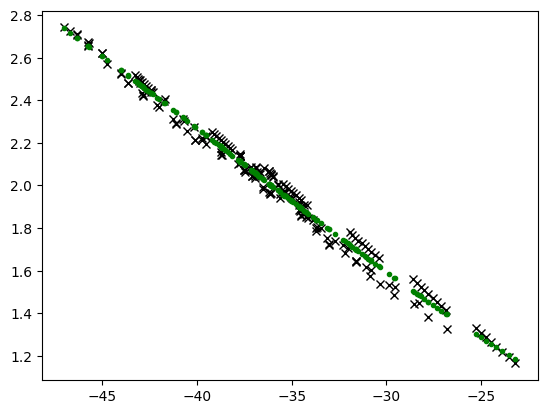

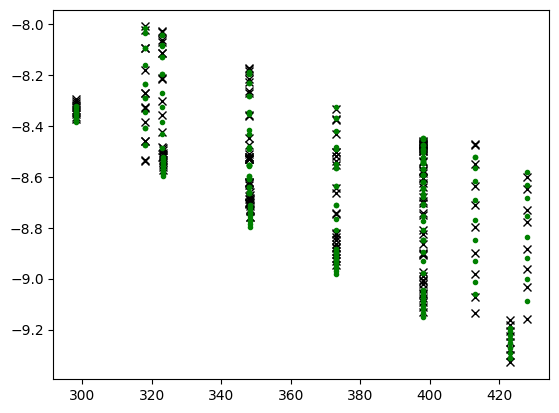

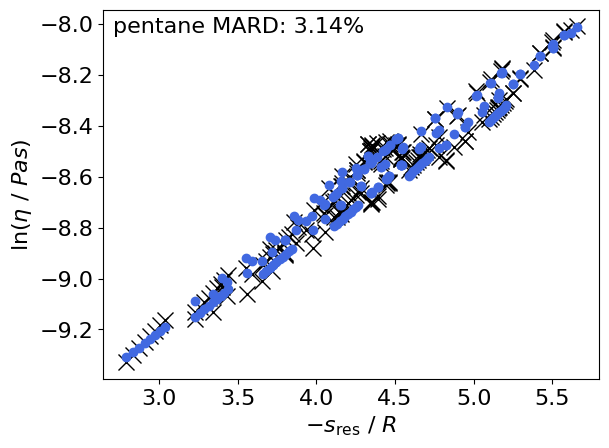

(np.float64(3.142819725963265),
 array([1.85697155e-05, 2.14826142e-03, 1.42927391e-02, 5.91165875e-01]),
 array([0.59116588]))

In [111]:
"""
Entropy Scaling for comparison
"""

vis = dummy["viscosity"]
log_vis = np.log(vis)
y_es = log_vis - np.log(dummy["eta_CE"])

es_model = np.polyfit(dummy["s_res"], y_es, 3)            


es_pred = np.poly1d(es_model)(dummy["s_res"])

eta_pred = es_pred + np.log(dummy["eta_CE"])


plt.plot( dummy["s_res"], y_es ,"kx")
plt.plot( dummy["s_res"], es_pred ,"g.")
plt.show()
plt.close()


plt.plot( dummy["temperature"], log_vis ,"kx")
plt.plot( dummy["temperature"], eta_pred ,"g.")
plt.show()
plt.close()


fig, ax = plt.subplots()

plt.plot( -dummy["s_res"]/8.314, log_vis ,"kx",markersize=msize)
plt.plot( -dummy["s_res"]/8.314, eta_pred ,".",color="royalblue",markersize=msize)


y = np.exp(eta_pred)

error = np.abs( ( vis - y )  / vis  )


plt.xlabel(r"$-s_\text{res}~/~R$",fontsize=fsize)
plt.ylabel(r"$\ln(\eta~/~Pas)$",fontsize=fsize)

error = np.mean(error)*100

plt.text(0.02, 0.98, name.split("_")[0]+' MARD: '+str(round(error,2))+"%",
     fontsize=fsize,
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  


plt.savefig(savepath+"/"+name+"/"+name+"_entropy_scaling.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_entropy_scaling.pdf",bbox_inches='tight')

plt.show()
plt.close()  

error, es_model, np.poly1d(es_model)( np.zeros(1) )

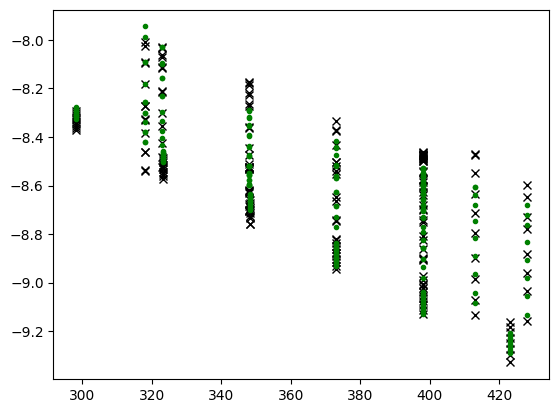

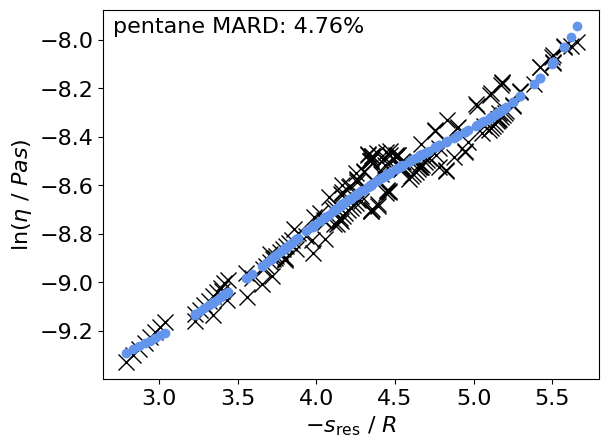

(np.float64(476.4598636398473),
 array([-7.00058631e-07, -1.09523028e-04, -6.66593947e-03, -1.96696080e-01,
        -2.85690797e+00, -2.59144389e+01]),
 array([-25.91443886]))

In [112]:
"""
Zero model for comparison
"""

vis = dummy["viscosity"]
log_vis = np.log(vis)

base_model = np.polyfit(dummy["s_res"], log_vis, 5)            


base_pred = np.poly1d(base_model)(dummy["s_res"])

plt.plot( dummy["temperature"], log_vis ,"kx")
plt.plot( dummy["temperature"], base_pred ,"g.")
plt.show()
plt.close()

fig, ax = plt.subplots()

plt.plot( -dummy["s_res"]/8.314, log_vis ,"kx",markersize=msize)
plt.plot( -dummy["s_res"]/8.314, base_pred ,".",color="cornflowerblue",markersize=msize)

y = np.exp(base_pred)

error = np.abs( ( vis - y )  / vis  )

error = np.mean(error)*100

plt.text(0.02, 0.98, name.split("_")[0]+' MARD: '+str(round(error,2))+"%",
     fontsize=fsize,
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  

plt.xlabel(r"$-s_\text{res}~/~R$",fontsize=fsize)
plt.ylabel(r"$\ln(\eta~/~Pas)$",fontsize=fsize)


plt.savefig(savepath+"/"+name+"/"+name+"_zero.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_zero.pdf",bbox_inches='tight')

plt.show()
plt.close()  

np.mean(error)*100, base_model, np.poly1d(base_model)( np.zeros(1) )

In [113]:
vis.shape

(186,)

In [114]:
if name == "nonane":
    model = EyringEntropyModel_EES0(parameters, dummy, p=[ 6, 1.1, 1.0, .1])
    print("nonane")
elif name == "hexane":
    model = EyringEntropyModel_EES0(parameters, dummy, p=[ 4, 1.1, 1.0, .1])
    print("hex")
elif name == "butanol":
    model = EyringEntropyModel_EES0(parameters, dummy, p=[ 3, 1.1, 1.0, .1])
    print("butanol")    
else:
    model = EyringEntropyModel_EES0(parameters, dummy, p=[ 2, 0.1, 1.0, .1])

model.train()

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 13416523.511294361
        x: [ 2.056e+00  1.419e-01  1.323e-01 -1.090e-02]
      nit: 32
      jac: [-1.474e+05 -4.045e+05 -1.157e+06 -4.525e+06]
     nfev: 260
     njev: 52
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

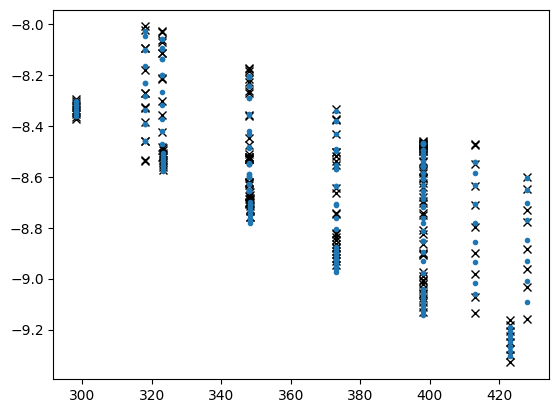

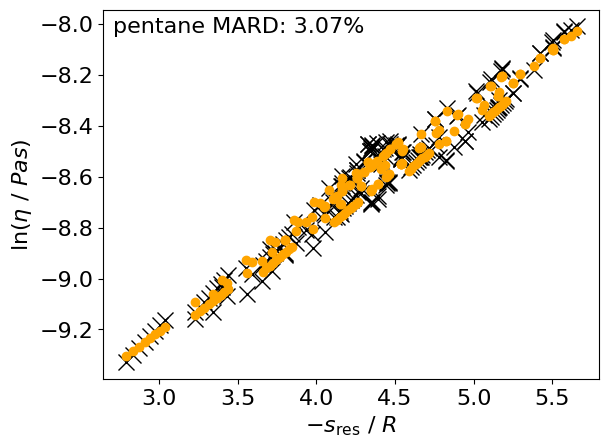

np.float64(3.0704409085623316)

In [115]:
"""
predict and show results plus error

"""

y_pred = model.predict()

plt.plot(model.data["temperature"],np.log(model.data["viscosity"]),"kx")
plt.plot(model.data["temperature"],y_pred,".")
plt.show()
plt.close()

fig, ax = plt.subplots()

plt.plot(-model.data["s_res"]/8.314,np.log(model.data["viscosity"]),"kx",markersize=msize)
plt.plot(-model.data["s_res"]/8.314,y_pred,".",color="orange",markersize=msize)

plt.xlabel(r"$-s_\text{res}~/~R$",fontsize=fsize)
plt.ylabel(r"$\ln(\eta~/~Pas)$",fontsize=fsize)

error = np.mean(np.abs( ( np.exp(y_pred) - model.data["viscosity"]) / model.data["viscosity"] ))*100

plt.text(0.02, 0.98, name.split("_")[0]+' MARD: '+str(round(error,2))+"%",
     fontsize=fsize,
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  


plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_mod0.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_mod0.pdf",bbox_inches='tight')

plt.show()
plt.close()  


error